In [1]:
import helpers as help
username = input("Enter database name")
password = input("Enter password")
load = help.DataBaseLoader(user=username, password=password, schema='mimiciv_derived')


# antibiotic_df = load['antibiotic'] # 6 seconds
# blood_differential_df = load['blood_differential'] # 30 seconds
# chemistry_df = load['chemistry'] # 20 seconds
vitalsign_df = load['vitalsign'] # 1 minute 20 seconds

In [2]:
load_mimic_hosp = help.DataBaseLoader(user=username, password=password, schema='mimiciv_hosp')
admissions = load_mimic_hosp['admissions']

In [ ]:
id_mapping = vitalsign_df.drop_duplicates(subset="stay_id")[["subject_id", "stay_id"]]

id_mapping.set_index('stay_id', inplace=True) 

print(id_mapping.loc[38141957][0])
id_mapping.head()

18139479


subject_id
stay_id             
39553978    10000032
39765666    10000980
34592300    10001217
37067082    10001217
31205490    10001725

In [4]:
load_greater_N = 70
hr_df = load.query(
        f"""
        WITH heartrate AS(
        SELECT subject_id, stay_id
        , charttime
        , heart_rate
        FROM vitalsign
        WHERE heart_rate IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.heart_rate) as num
            FROM heartrate h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {load_greater_N}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.heart_rate
        FROM heartrate v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
sysbp_df = load.query(
        f"""
        WITH sysbp AS(
        SELECT subject_id, stay_id
        , charttime
        , sbp
        FROM vitalsign
        WHERE sbp IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.sbp) as num
            FROM sysbp h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {load_greater_N}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.sbp
        FROM sysbp v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
diabp_df = load.query(
        f"""
        WITH diabp AS(
        SELECT subject_id, stay_id
        , charttime
        , dbp
        FROM vitalsign
        WHERE dbp IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.dbp) as num
            FROM diabp h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {load_greater_N}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.dbp
        FROM diabp v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
resp_df = load.query(
        f"""
        WITH resp AS(
        SELECT subject_id, stay_id
        , charttime
        , resp_rate
        FROM vitalsign
        WHERE resp_rate IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.resp_rate) as num
            FROM resp h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {load_greater_N}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.resp_rate
        FROM resp v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
oxySat_df = load.query(
        f"""
        WITH oxysat AS(
        SELECT subject_id, stay_id
        , charttime
        , spo2
        FROM vitalsign
        WHERE spo2 IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.spo2) as num
            FROM oxysat h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {load_greater_N}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.spo2
        FROM oxysat v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
print(len(hr_df['stay_id'].unique()))
print(len(sysbp_df['stay_id'].unique()))
print(len(diabp_df['stay_id'].unique()))
print(len(resp_df['stay_id'].unique()))
print(len(oxySat_df['stay_id'].unique()))

25970
25064
25058
25769
25224


In [5]:
which_id = 'stay_id'
hr_ids = set(hr_df[which_id].unique())
sysbp_ids = set(sysbp_df[which_id].unique())
diabp_ids = set(diabp_df[which_id].unique())
resp_ids = set(resp_df[which_id].unique())
oxySat_ids = set(oxySat_df[which_id].unique())

intersection = sysbp_ids & hr_ids & diabp_ids & resp_ids & oxySat_ids
print(len(intersection))
vitalsigns_stay_ids = [*intersection,]

23797


In [6]:
chem_min_measurement = 1
glucose_df = load.query(
    f"""
    WITH chem AS(
    SELECT *
    FROM chemistry
    WHERE glucose IS NOT NULL
    )
    , count_measurement AS(
        SELECT b.hadm_id, COUNT(b.glucose) as num
        FROM chem b
        GROUP BY b.hadm_id
    )
    , filtered AS (
        SELECT hadm_id, num
        FROM count_measurement
        WHERE num >= {chem_min_measurement}
    )
    SELECT *
    FROM chem v
    INNER JOIN filtered f
        ON v.hadm_id = f.hadm_id
    """
)
glucose_df = glucose_df.loc[:,~glucose_df.columns.duplicated()].copy()
# glucose_df.drop("num", axis=1, inplace=True) # axis=1 means columns
glucose_df = glucose_df[['subject_id', 'charttime', 'glucose']]
creatinine_df = load.query(
    f"""
    WITH chem AS(
    SELECT *
    FROM chemistry
    WHERE creatinine IS NOT NULL
    )
    , count_measurement AS(
        SELECT b.hadm_id, COUNT(b.creatinine) as num
        FROM chem b
        GROUP BY b.hadm_id
    )
    , filtered AS (
        SELECT hadm_id, num
        FROM count_measurement
        WHERE num >= {chem_min_measurement}
    )
    SELECT *
    FROM chem v
    INNER JOIN filtered f
        ON v.hadm_id = f.hadm_id
    """
)
creatinine_df = creatinine_df.loc[:,~creatinine_df.columns.duplicated()].copy()
creatinine_df = creatinine_df[['subject_id', 'charttime', 'creatinine']]
sodium_df = load.query(
    f"""
    WITH chem AS(
    SELECT *
    FROM chemistry
    WHERE sodium IS NOT NULL
    )
    , count_measurement AS(
        SELECT b.hadm_id, COUNT(b.sodium) as num
        FROM chem b
        GROUP BY b.hadm_id
    )
    , filtered AS (
        SELECT hadm_id, num
        FROM count_measurement
        WHERE num >= {chem_min_measurement}
    )
    SELECT *
    FROM chem v
    INNER JOIN filtered f
        ON v.hadm_id = f.hadm_id
    """
)
sodium_df = sodium_df.loc[:,~sodium_df.columns.duplicated()].copy()
sodium_df = sodium_df[['subject_id', 'charttime', 'sodium']]

chem_intersection = set(glucose_df['subject_id'].unique()) & set(creatinine_df['subject_id'].unique()) & set(sodium_df['subject_id'].unique()) 
len(chem_intersection)

138269

### Finding overlapping patients with ICD codes, vital signs, and chemistry

In [7]:
import _pickle as pickle

vitalsigns_subjectid_set = set(id_mapping.loc[vitalsigns_stay_ids]["subject_id"].drop_duplicates().tolist())
file = open('data/mimiciv_icd/patient_ids_in_order.list', 'rb')
icd_patient_ids_in_order = pickle.load(file)
file.close()
icd_set = set(icd_patient_ids_in_order)
# intersection = vitalsigns_set & icd_set & chem_intersection
intersection = vitalsigns_subjectid_set & chem_intersection
print(len(intersection))

# NOTE: make sure just using subject_id works
vital_chem_patient_list = [*intersection,]

19139


### Load in ICD data

In [8]:
file = open('data/mimiciv_icd/icd_codes_in_order.list', 'rb')
icd_order = pickle.load(file)
file.close()
file = open('data/mimiciv_icd/binary_icd.matrix', 'rb')
icd_matrix = pickle.load(file)   # rows is patients, columns is icd code
file.close()
file = open('data/mimiciv_icd/patient_to_index.dict', 'rb')
patient_to_index = pickle.load(file)   # rows is patients, columns is icd code
file.close()


In [9]:
expired = admissions[admissions['hospital_expire_flag'] == 1]
expired_subject_ids = expired[['subject_id']]
expired_subject_ids = set(expired_subject_ids['subject_id'])
type(expired_subject_ids) # set type, O(1) search complexity

set

## Generate dataset before processing

In [10]:
import numpy as np

from tqdm import tqdm

list = ["heart_rate", "sbp", "dbp", "resp_rate", "spo2", "glucose", "creatinine", "sodium"]
df_list = [hr_df, sysbp_df, diabp_df, resp_df, oxySat_df, glucose_df, creatinine_df, sodium_df]
min_length = float("inf")
num_points, num_nan = [], []
df_id_sets = []
for df in df_list:
    df_id_sets.append(df['subject_id'].unique())

num_icd_codes = 13365

subject_ids = set()

processed_data = []

for stay_id in tqdm(vitalsigns_stay_ids): # here is stay_id
    subject_id = id_mapping.loc[stay_id]["subject_id"]
    
    feature_data = [] 
    
    c = 0
    
    for df_index, feature in enumerate(list):
        if df_index < 5: # if vital sign measurement, use stay_id
            patient_id = stay_id
        else: # rest use subject_id
            patient_id = subject_id
        
        if c >= 5 and subject_id not in df_id_sets[df_index]: # does not have chemistry measurement
            a = np.empty(72)
            a[:] = np.nan
        
            feature_data.append(a)
            feature_data.append(np.isnan(a).astype(int))
        else:
            if df_index < 5: 
                specific_df = df_list[df_index][df_list[df_index]['stay_id'] == patient_id]           
            else:
                specific_df = df_list[df_index][df_list[df_index]['subject_id'] == patient_id]           

            specific_df = specific_df[['charttime', feature]]          # only keep the columns we need
            if c >= 5: # infrequent measurements
                specific_df['charttime'] = specific_df['charttime'].dt.round('20min')
            specific_df.set_index('charttime', inplace=True)        # set the index to be charttime
            specific_df = specific_df[~specific_df.index.duplicated()] # remove charttime duplicates (only should be from rounding)
            
            # num_points.append(specific_df.shape[0])
            
            df_hourly = specific_df.resample('H').asfreq()  # Resample to hourly frequency
            # num_nan.append(df_hourly.isna().sum().sum())
            
            temp = df_hourly[feature].to_numpy()
            
            if len(temp) >= 72:
                feature_data.append(temp)
                feature_data.append(np.isnan(temp).astype(int))
            
        c+=1
    
    # add ICD codes if patient has ICD code
    if subject_id in patient_to_index:
        icd_vector = icd_matrix[patient_to_index[subject_id]]
        feature_data.append(icd_vector[:len(temp)])
    else: # if no ICD codes, empty 0 vector
        feature_data.append(np.zeros(len(temp)))
        
    # add expired indicator
    if subject_id in expired_subject_ids:    
        feature_data.append(np.ones(len(temp)))
    else: 
        feature_data.append(np.zeros(len(temp)))
    
    if len(feature_data) == 18: # 8 features * 2, + 1 for icd, + 1 for expired
        processed_data.append(feature_data)
        subject_ids.add(subject_id)
    # print()

# subject_ids = np.array(subject_ids)
print(len(subject_ids))
len(processed_data)
    

100%|██████████| 23797/23797 [08:00<00:00, 49.57it/s]

17294


21373

In [11]:
import torch

N = 72
input = np.zeros((len(processed_data), (len(list) * 2) + 2, N))

for i, patient_data in enumerate(processed_data):
    for j, feature in enumerate(processed_data[i]):
        input[i][j] = processed_data[i][j][:N]

input.shape


(21373, 18, 72)

In [12]:
# NanArray = np.isnan(input)
# nan_indices = np.where(np.isnan(input))
# nan_indices[0]
print(np.isnan(input).any())

True


In [13]:
import matplotlib.pyplot as plt
import random
text_size = 20
def graph(samples, channel_num):
    rows, cols = 10, ((channel_num-2) // 2) + 2
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*10, rows*5) )
    
    
    sample_patients = random.sample(range(0, len(samples)), rows)
            
    for patient_num, patient_index in enumerate(sample_patients): 
        patient = samples[patient_index]
        
        
        feature_label = ["Heart Rate (Beats/Min)", "SBP (mm Hg)", "DBP (mm Hg)", "Resp. Rate (Breaths/Min)", "SPO2 (%)", "Glucose", "Creatinine", "Sodium", "ICD", "Mortality (1/0)"]
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for feature_index in range(channel_num//2):    # even numbers are the values              
            channel_index = feature_index * 2
            
            patient_series = patient[channel_index]
            patient_series = np.where(patient[channel_index+1] == 1, np.nan, patient[channel_index])
        
            # plot own graph
            if feature_index >= 5:
                axes[patient_num, feature_index].scatter(np.arange(1, len(patient_series)+1), patient_series, label = feature_label[feature_index], color = cycle[feature_index])
            else:
                axes[patient_num, feature_index].plot(np.arange(1, len(patient_series)+1), patient_series, label = feature_label[feature_index], color = cycle[feature_index])
            axes[patient_num, feature_index].legend(loc="upper right", fontsize = text_size)
            axes[patient_num, feature_index].set_xlabel("Time (every 1 hour)")
            axes[patient_num, feature_index].set_ylabel("Value")
            # plot overlapping graph
            axes[patient_num, channel_num//2].plot(np.arange(1, len(patient_series)+1), patient_series, label = feature_label[feature_index]) 
            
        axes[patient_num, channel_num//2].legend(loc="upper right", fontsize = 12)
        axes[patient_num, channel_num//2].set_xlabel("Time (every 1 hour)")
        axes[patient_num, channel_num//2].set_ylabel("Value")
        
        # plot icd
        axes[patient_num, cols-2].scatter(np.arange(1, len(patient_series)+1), patient[-2], label=feature_label[-2], color=cycle[-2])
        axes[patient_num, cols-2].legend(loc="upper right", fontsize = text_size)
        
        # plot mortality
        axes[patient_num, cols-1].plot(np.arange(1, len(patient_series)+1), patient[-1], label=feature_label[-1], color=cycle[-1])
        axes[patient_num, cols-1].legend(loc="upper right", fontsize = text_size)
            
    plt.tight_layout()
    plt.show()
    plt.close

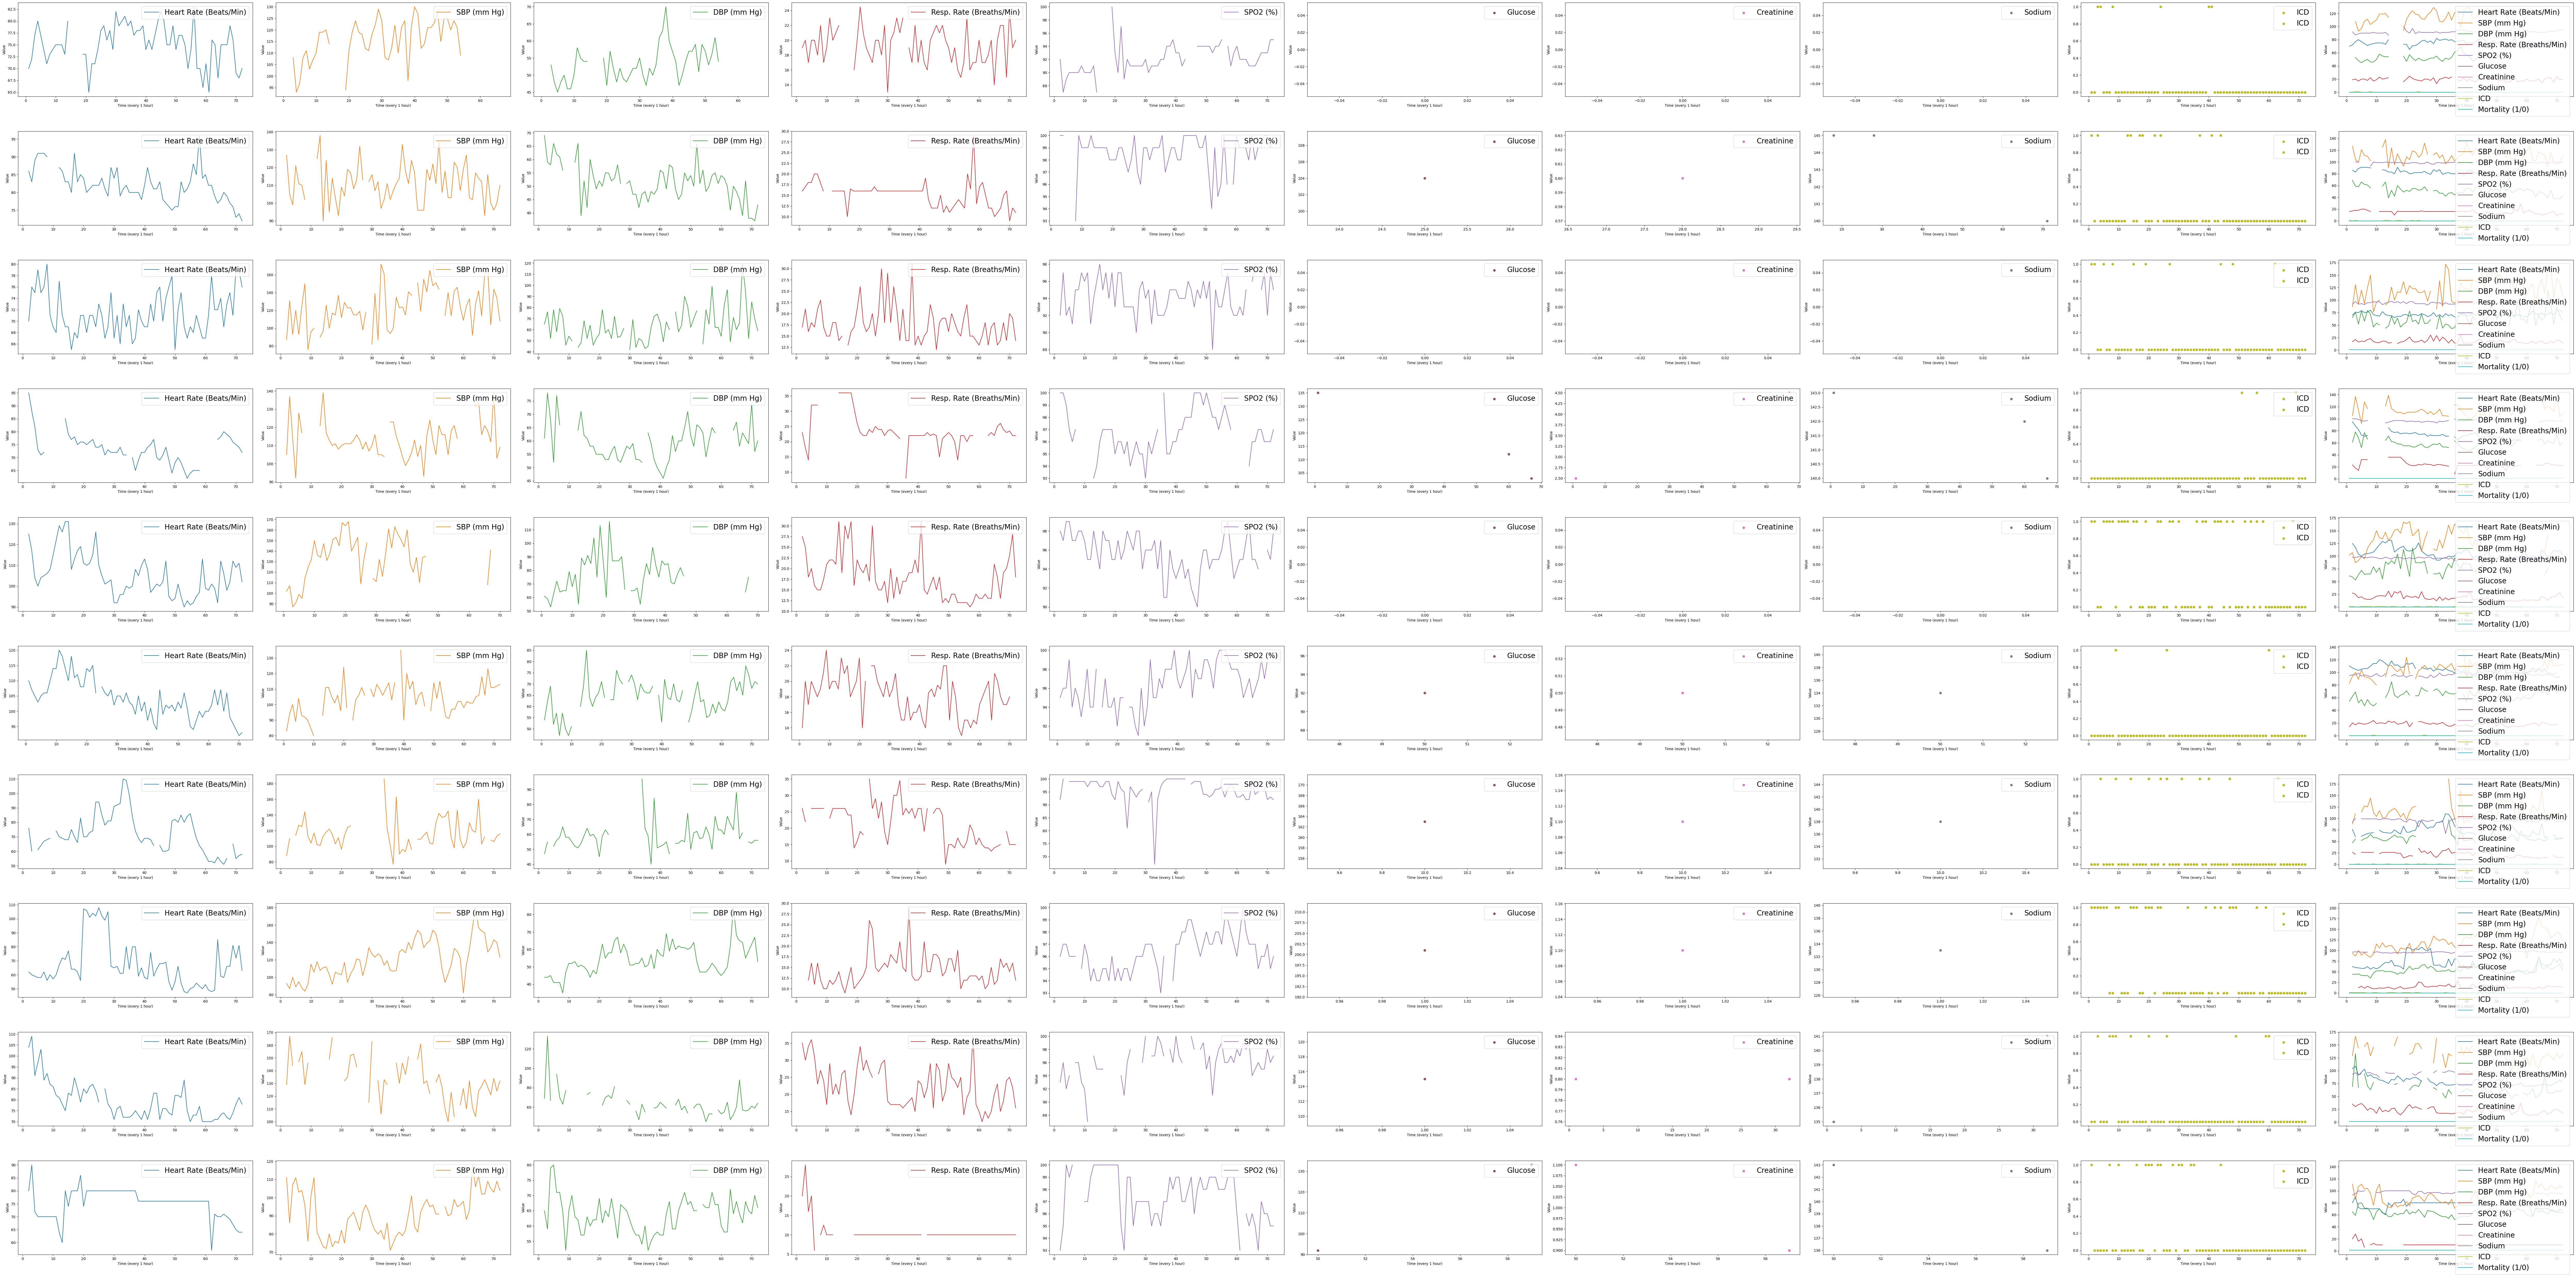

In [14]:
graph(input, 18)

In [15]:
# keep mortality only
# np.squeeze(input[:,10:,:1]).shape
input[200][14]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 146.,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 142.,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])

In [16]:
from helpers import seed_everything
from sklearn.model_selection import train_test_split
seed_everything(2023)


np.random.shuffle(input)


train_num = int(len(input) * 0.75) 
test_num = int(len(input) - train_num)
    
# X is input, Y is just mortality indicator (input X still contains mortality)
X, y = input, np.squeeze(input[:,-1:,:1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_num, train_size=train_num, random_state=2023, shuffle=True, stratify=y)

print(len(X_train))
print(len(X_test))
torch.save(torch.from_numpy(X_train), "data/mimiciv_time_irregular_icd/mort_added_trainingSamples.pt")
torch.save(torch.from_numpy(X_test), "data/mimiciv_time_irregular_icd/mort_added_testingSamples.pt")


Seed set to 2023

16029
5344


In [17]:
import pickle

pickle.dump(vitalsigns_set, open("data/mimiciv_time_irregular_icd/dataset_ids"+".set", 'wb'), -1)

NameError: name 'vitalsigns_set' is not defined